In [127]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from scipy import signal
from scipy.constants import hbar, eV
from scipy.optimize import curve_fit
import qutip as qt
from tqdm import tqdm

In [128]:
x = np.load('fft_data/x.npy')
y = np.load('fft_data/y.npy')
z = np.load('fft_data/z.npy')

x = x[0]

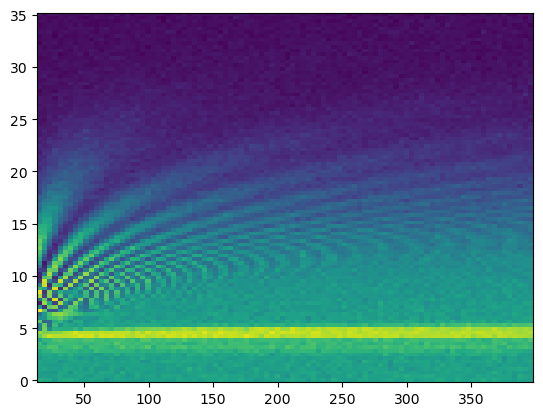

In [129]:
plt.figure()
plt.pcolor(x, y, z, cmap='viridis_r')

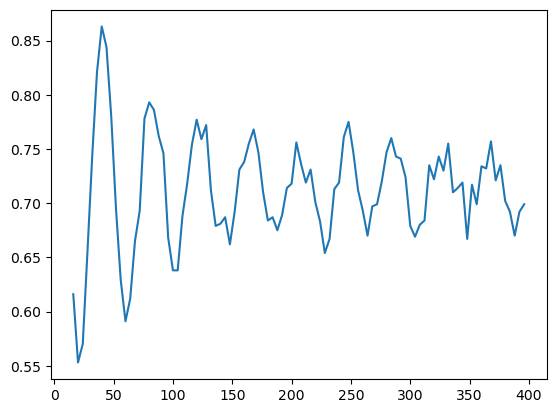

In [130]:
detuning = 15
plt.figure()
plt.plot(x, z[np.argmin(np.abs(y - detuning))], label='detuning = %d MHz' % detuning)

## 周波数の抽出

In [131]:
z_fft = fft.fft(z, axis=1)
x_fft = np.linspace(0, 250, z.shape[1])


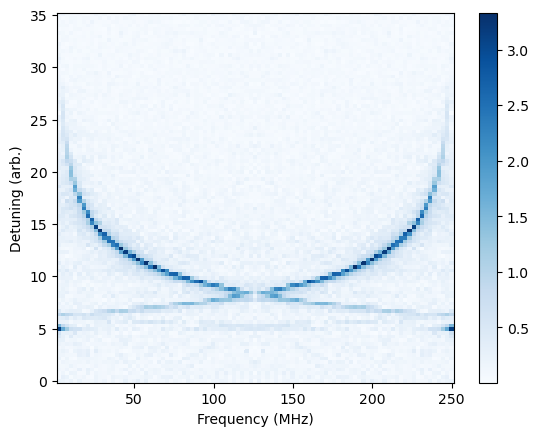

In [132]:
plt.figure()
plt.pcolor(x_fft[1:], y, np.abs(z_fft[:, 1:]), cmap='Blues')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Detuning (arb.)')
plt.colorbar()

In [133]:
import plotly.express as px

fig = px.imshow(np.abs(z_fft)[:, 1:], aspect='auto', color_continuous_scale='Blues')
fig.show()

In [134]:
z_fft_masked = np.copy(z_fft)

z_fft_masked[:75, 48:] = 0
z_fft_masked[77:, :46] = 0
z_fft_masked[:76, 50:] = 0
z_fft_masked[84:] = 0

In [135]:
fig = px.imshow(np.abs(z_fft_masked)[:, 1:], aspect='auto', color_continuous_scale='Blues')
fig.show()

In [136]:
from plotly.subplots import make_subplots
from plotly import graph_objects as go


# サブプロット作成（ヒートマップとスライス）
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    row_heights=[0.7, 0.3], vertical_spacing=0.05)

# ヒートマップ追加
heatmap = go.Heatmap(z=np.abs(z_fft_masked)[:, 1:], x=x[1:], y=y, colorbar=dict(title="Intensity"))
fig.add_trace(heatmap, row=1, col=1)

# 初期スライス y=0番目
initial_index = 0
slice_line = go.Scatter(x=x, y=np.abs(z_fft_masked)[len(z_fft_masked)//2, 1:], mode='lines',
                        name=f'y = {y[initial_index]:.2f}')
fig.add_trace(slice_line, row=2, col=1)

# スライダー用フレーム作成
steps = []
for i in range(len(y)):
    step = dict(
        method="update",
        args=[{"y": [None, np.abs(z_fft_masked)[i, 1:]]},  # 2番目のトレースのみ更新
              {"annotations": []}],
        label=f"y = {y[i]:.2f}"
    )
    steps.append(step)

sliders = [dict(
    active=initial_index,
    currentvalue={"prefix": "Slice at "},
    steps=steps
)]

# スライダー追加
fig.update_layout(
    sliders=sliders,
    height=600,
    title="2D Heatmap with Interactive X-axis Slice (via y selection)"
)

fig.show()


In [137]:
from scipy.optimize import curve_fit

def gaussian(f, A, f0, sigma, offset):
    return A * np.exp(-(f - f0)**2 / (2 * sigma**2)) + offset

peak = []
error = []

for i in range(len(y)):
    signal = np.abs(z_fft_masked[i, 1:])
    freq = x_fft[1:]

    # 初期値の推定
    A0 = np.max(signal)
    f0 = freq[np.argmax(signal)]
    sigma0 = 10  # MHz スケールで仮定
    offset0 = np.min(signal)

    try:
        popt, pcov = curve_fit(gaussian, freq, signal, p0=[A0, f0, sigma0, offset0])
        peak.append(popt[1])             # f0
        error.append(np.sqrt(np.diag(pcov))[1])  # f0 の標準偏差
        # error.append(popt[2])
    except RuntimeError:
        peak.append(f0)
        error.append(np.nan)


C:\Users\hideb\AppData\Local\Temp\ipykernel_8396\4120372554.py:20: OptimizeWarning:

Covariance of the parameters could not be estimated



Text(0.5, 1.0, 'Frequency vs Detuning')

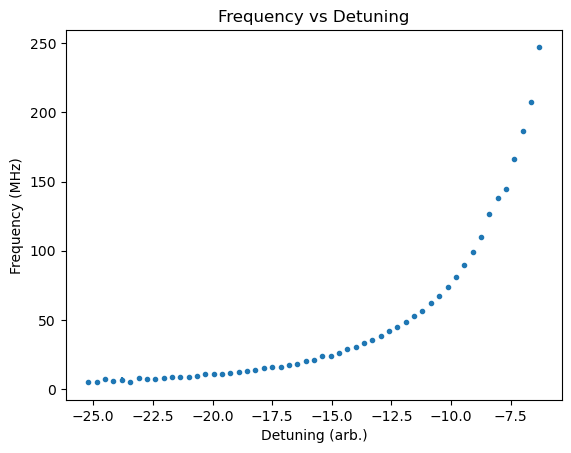

In [138]:
start = 28; end = 83
# y_ = -y[:]
# peak = np.array(peak)[:83]
# error = np.array(error)[:83]

plt.figure()
plt.errorbar(-y[start:end], peak[start:end], yerr=error[start:end],
            fmt='o', markersize=3, label='Peak Frequency')
# plt.plot(-y, peak, markersize=3, label='Peak Frequency')
plt.xlabel('Detuning (arb.)')
plt.ylabel('Frequency (MHz)')
plt.title('Frequency vs Detuning')

In [140]:
y_ = -y[start:end]
peak = np.array(peak)[start:end] * 2*np.pi
error = np.array(error)[start:end] * 2*np.pi

## 線形なトンネリング

In [141]:
import qutip as qt

MHz = 1e6 * 2 * np.pi  # MHz to Hz
meV2Hz = 2.418e14 * 1e-3 * 2 * np.pi  # meV(mV) to Hz

dB = 1 * MHz
# t = 10 * MHz
a = -0.03 * meV2Hz  # lever arm
U = -1.3 * a
c0 = 1500 * MHz
c1 = 0.0007 * meV2Hz

def H_lin(eps, c0=c0, c1=c1, dB=dB, a=a, U=U):
    # exponential tunneling
    # t = c0 + c1 * np.exp(c2 * eps)

    # linear tunneling
    t = c0 + c1 * (eps + 13)

    # return qt.Qobj([[0, dB, 0],
    #                  [dB, 0, t],
    #                  [0, t, U + a*eps]])
    J = - 2 * t**2 / (U + a * eps)
    return qt.Qobj([[0, dB],
                     [dB, J]])


In [60]:
energies = []
for eps in y_:
    H_eps = H_lin(eps)
    energies.append(H_eps.eigenenergies())
energies = np.array(energies)

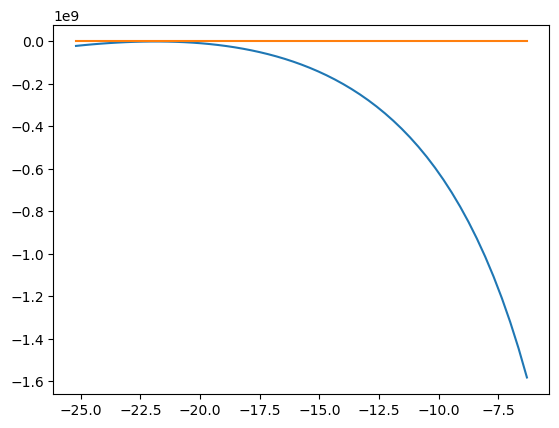

In [61]:
for i in range(2):
    plt.plot(y_, energies[:,i])

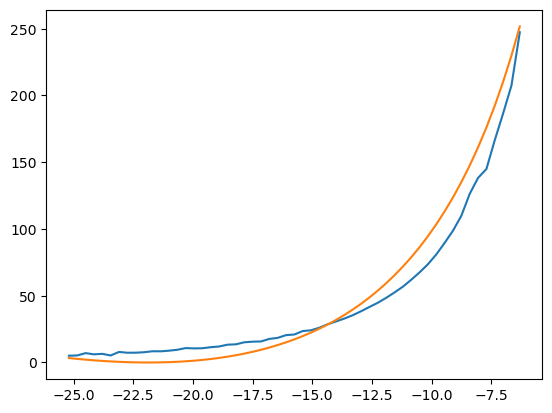

In [62]:
plt.figure()
plt.plot(y_, peak / (2*np.pi))
plt.plot(y_, 1e-6*(energies[:, 1] - energies[:, 0]) / (2*np.pi))

In [63]:
from scipy.optimize import curve_fit

def ST_energy_fit(eps_array, c0, c1):
    t = c0 + c1 * (eps_array + 13)
    J = 2 * t**2 / (U + a * eps_array)
    dE = np.sqrt(J**2 + 4*dB**2)
    return dE * 1e-6

# Initial guess for c0 and c1
p0 = [c0, c1]
popt1, pcov1 = curve_fit(ST_energy_fit, y_, peak, p0=p0)

Fitted parameters:
c0: 1394.5748887814786 MHz
c1: 1005.5709939780788 MHz/meV


Text(0.5, 1.0, 'Frequency vs Detuning with Fit')

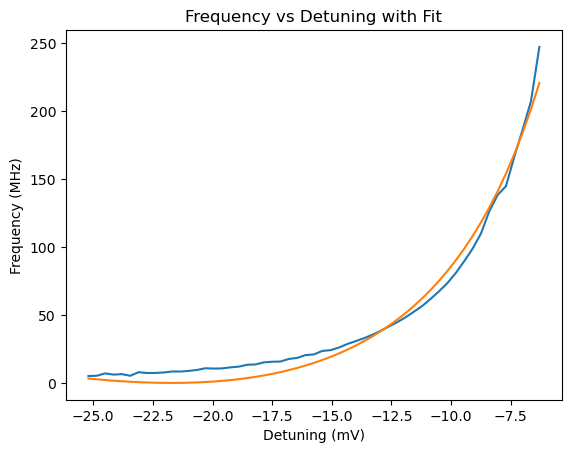

In [64]:
print("Fitted parameters:")
print("c0:", popt1[0] / MHz, "MHz")
print("c1:", popt1[1] * 1e-6, "MHz/meV")

plt.figure()
plt.plot(y_, peak / (2*np.pi))
plt.plot(y_, ST_energy_fit(y_, c0=popt1[0], c1=popt1[1]) / (2*np.pi))
# plt.plot(y_, ST_energy_fit(y_, *popt1))
plt.xlabel('Detuning (mV)')
plt.ylabel('Frequency (MHz)')
plt.title('Frequency vs Detuning with Fit')


## 指数関数

In [156]:
dB = 1 * MHz
# t = 10 * MHz
a = -0.03 * meV2Hz  # lever arm
U = -1.3 * a
d0 = 1 * MHz
d1 = 2000 * MHz
d2 = 0.07

def H_exp(eps, d0=d0, d1=d1, d2=d2, dB=dB, a=a, U=U):
    # exponential tunneling
    t = d0 + d1 * np.exp(d2 * (eps+13))

    return qt.Qobj([[0, dB, 0],
                     [dB, 0, t],
                     [0, t, U + a*eps]])

    # J = - 2 * t**2 / (U + a * eps)
    # return qt.Qobj([[0, dB],
    #                  [dB, J]])


In [157]:
energies = []
for eps in y_:
    H_eps = H_exp(eps, d0=d0, d1=d1, d2=d2, a=a)
    energies.append(H_eps.eigenenergies())
energies = np.array(energies)

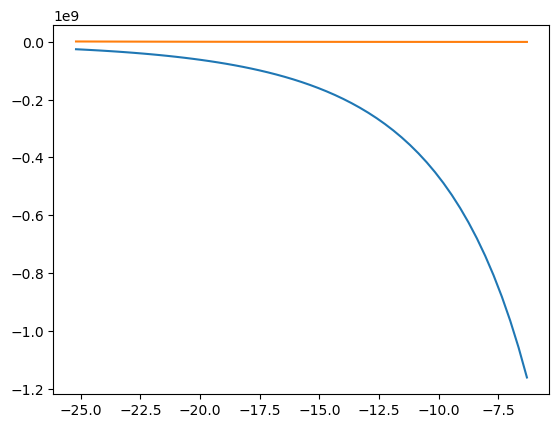

In [158]:
for i in range(2):
    plt.plot(y_, energies[:,i])

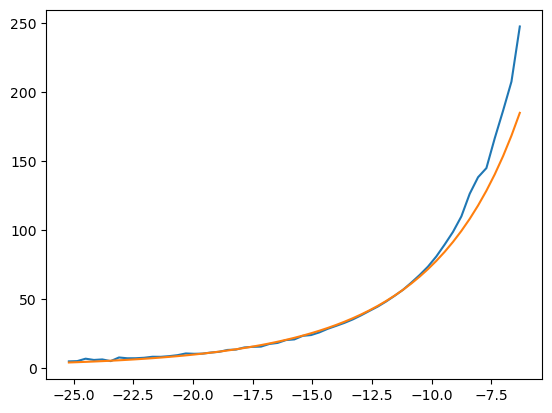

In [159]:
plt.figure()
plt.plot(y_, peak / (2*np.pi))
plt.plot(y_, 1e-6*(energies[:, 1] - energies[:, 0]) / (2*np.pi))

In [160]:
def ST_energy_exp_fit(eps_array, d0, d1, d2):
    results = []
    for eps in eps_array:
        H_eps = H_exp(float(eps), d0=d0, d1=d1, d2=d2, dB=dB, a=a)
        evals = H_eps.eigenenergies()
        E_model = (evals[1] - evals[0]) * 1e-6  # [MHz]
        results.append(E_model)
    return np.array(results)


# Initial guess for c0 and c1
p0 = [0, d1, d2]
popt2, pcov2 = curve_fit(ST_energy_exp_fit, y_, peak, p0=p0,
                        bounds=(0, [1*MHz, np.inf, np.inf]))
                        #  sigma=error, absolute_sigma=True,
                        #  method='lm', ftol=1e-90, xtol=1e-20, gtol=1e-20)

print("Fitted parameters:")
print("d0:", popt2[0] / MHz, "MHz")
print("d1:", popt2[1] / MHz, "MHz")
print("d2:", popt2[2])
# print("dB:", popt2[3] / MHz, "MHz")


Fitted parameters:
d0: 1.5915494309189534e-17 MHz
d1: 1999.9999999999932 MHz
d2: 0.08670449743216944


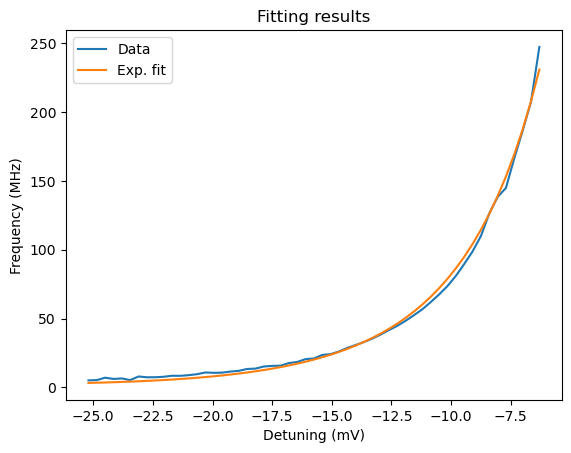

In [161]:
plt.figure()
plt.plot(y_, peak / (2*np.pi), label='Data')
# plt.plot(y_, ST_energy_fit(y_, *popt1), label='Lin. fit')
plt.plot(y_, ST_energy_exp_fit(y_, *popt2) / (2*np.pi), label='Exp. fit')
plt.xlabel('Detuning (mV)')
plt.ylabel('Frequency (MHz)')
plt.title('Fitting results')
plt.legend()


## 時間発展

In [162]:

d0 = popt2[0]
d1 = popt2[1]
d2 = popt2[2]
# dB = popt2[3]

### define the time dependent hamiltonian
def H_exp(eps, d0=d0, d1=d1, d2=d2, dB=dB, a=a, U=U):
    # exponential tunneling
    t = d0 + d1 * np.exp(d2 * (eps + 13))

    return qt.Qobj([[0, dB, 0],
                     [dB, 0, t],
                     [0, t, U + a*eps]])


In [163]:
eigen = H_exp(-35).eigenstates()[1]
psi0 = eigen[0]

tlist = np.linspace(0, 400e-9, 5000)
# result = qt.mesolve(H_exp(-15), psi0, tlist)

In [164]:
from tqdm import tqdm

eigen = H_exp(-35).eigenstates()[1]
psi0 = eigen[0]

result = []
populations = []
detuning_list = np.linspace(-0, -35, 100)
for ieps in tqdm(detuning_list):
    if ieps > -5:
        populations.append(np.ones_like(tlist))
        continue
    res = qt.mesolve(H_exp(ieps), psi0, tlist)
    result.append(res)
    populations.append(
        qt.expect(qt.ket2dm(eigen[0]), res.states)
    )


100%|██████████| 100/100 [07:25<00:00,  4.45s/it]


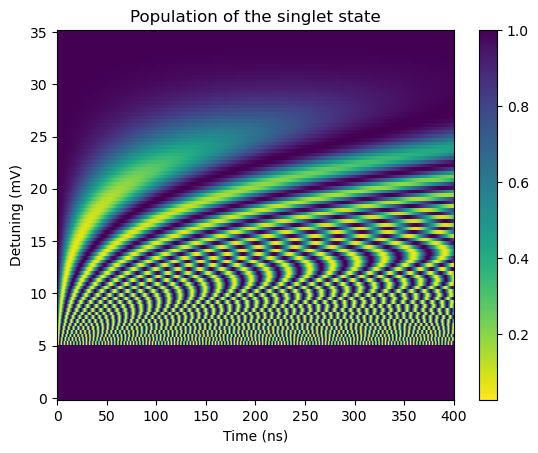

In [165]:
plt.figure()
plt.pcolor(tlist * 1e9, -detuning_list, populations, cmap='viridis_r')
plt.xlabel('Time (ns)')
plt.ylabel('Detuning (mV)')
plt.title('Population of the singlet state')
plt.colorbar()
plt.show()


In [167]:
c0 = popt1[0]
c1 = popt1[1]

d0 = popt2[0]
d1 = popt2[1]
d2 = popt2[2]
# dB = popt2[3]

# Define the time dependence parameters
offset = -15
freq = 40 * MHz
amplitude = 5

### define the time dependent hamiltonian
# Constant part
H_0 = qt.Qobj([[0, dB, 0],
               [dB, 0, 0],
               [0,  0, U]])

# Tunneling term
H_1 = qt.Qobj([[0, 0, 0],
               [0, 0, 1],
               [0, 1, 0]])

# Detuning term
H_2 = qt.Qobj([[0, 0, 0],
               [0, 0, 0],
               [0, 0, 1]])

# Define each time dependence function
def eps(t, args):
    return args['offset'] + np.sin(2*np.pi * t * args['freq']) * args['amplitude']

def f1(t, args):
    return d0 + d1 * np.exp(d2 * (eps(t, args)))

def f2(t, args):
    return a * eps(t, args)

# Combine into a QObjEvo
H = qt.QobjEvo([H_0, [H_1, f1], [H_2, f2]], args={'offset': offset, 'freq': freq, 'amplitude': amplitude})

In [168]:
# Initial state
eigen = H(0).eigenstates()[1]
psi0 = eigen[0]  # Ground state
psi0 = qt.ket2dm(psi0)
# Time evolution
tlist = np.linspace(0, 400e-9, 4000)
args = {'offset': offset, 'freq': freq, 'amplitude': amplitude}
result = qt.mesolve(H, psi0, tlist, args=args)

Text(0.5, 1.0, 'FFT of Energy Difference')

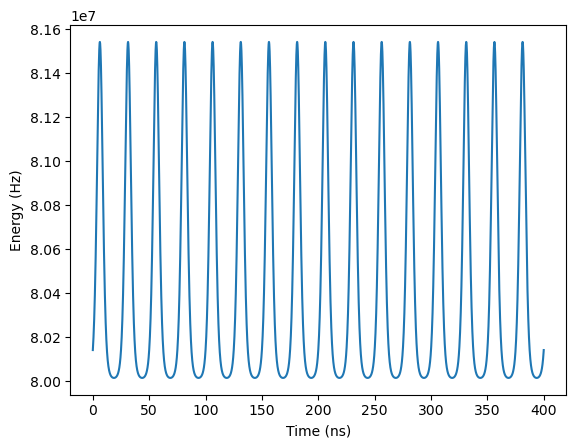

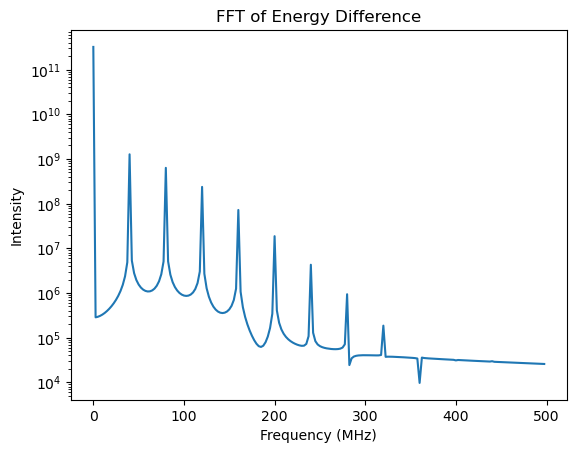

In [26]:
plt.figure()
# plt.plot(tlist * 1e9, f1(tlist, args), label='Detuning')
e = []
for time in tlist:
    e.append(H(time).eigenstates()[0])
e = np.array(e)
# plt.plot(tlist * 1e9, e[:, 0], label='Ground state')
# plt.plot(tlist * 1e9, e[:, 1], label='First excited state')
# plt.plot(tlist * 1e9, e[:, 2], label='Second excited state')
plt.plot(tlist * 1e9, e[:, 1] - e[:, 0], label='Energy difference')
plt.xlabel('Time (ns)')
plt.ylabel('Energy (Hz)')

plt.figure()
Ediff = e[:, 1] - e[:, 0]
Edifft = np.fft.fft(Ediff)
tlistfft = np.fft.fftfreq(len(tlist), tlist[1] - tlist[0])
plt.plot(tlistfft[:200] * 1e-6, np.abs(Edifft)[:200], label='Energy difference')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Intensity')
plt.title('FFT of Energy Difference')


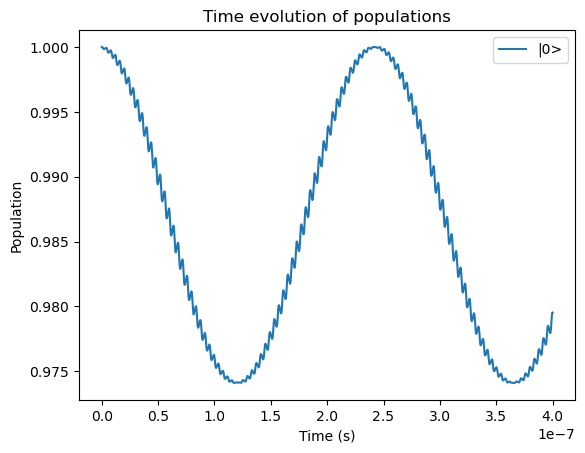

In [169]:
populations = np.array([qt.expect(qt.ket2dm(eigen[i]), result.states) for i in range(3)])

plt.figure()
plt.plot(tlist, populations[0, :], label='|0>')
# plt.plot(tlist, populations[1, :], label='|1>')
# plt.plot(tlist, populations[2, :], label='|2>')
plt.xlabel('Time (s)')
plt.ylabel('Population')
plt.title('Time evolution of populations')
plt.legend()
plt.show()

In [171]:
freq_list = np.linspace(0, 50, 100) * MHz
Ps_prob = []
for freq in tqdm(freq_list):
    args = {'offset': offset, 'freq': freq, 'amplitude': amplitude}
    result = qt.mesolve(H, psi0, tlist, args=args)
    populations = np.array([qt.expect(qt.ket2dm(eigen[i]), result.states) for i in range(3)])
    Ps_prob.append(populations[0, :])

Ps_prob = np.array(Ps_prob)


100%|██████████| 100/100 [24:55<00:00, 14.95s/it]


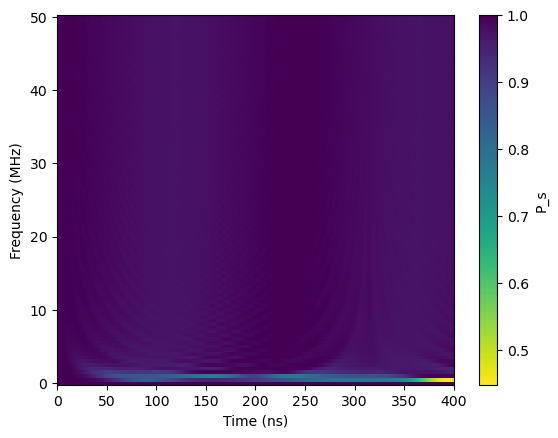

In [172]:
plt.figure()
plt.pcolor(tlist * 1e9, freq_list / MHz, Ps_prob, cmap='viridis_r')
plt.xlabel('Time (ns)')
plt.ylabel('Frequency (MHz)')
plt.colorbar(label='P_s')

In [146]:
# 定数（CODATA 2018ベース）
eV_to_J = 1.602176634e-19  # [J/eV]
h = 6.62607015e-34         # [J·s]

# meV → Hz
print((1e-3 * eV_to_J) / h *1e-11)  # ≈ 2.418e11 Hz

# Hz → meV
# Hz2meV = h / (1e-3 * eV_to_J)  # ≈ 4.1357e-3 meV


2.417989242084918
